In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from asi import path_config

session2 = path_config.measurements / "session2"

# Segmentation: Specium Scanner, GreenSamplesVisible

In [ ]:
from asi.draw import reconstruct_rgb_envi
from asi.preprocess import load_white_corrected

specim_iq = session2 / "Specim scanner" / "GreenSamplesVisible" / "capture"

image_path = specim_iq / "solutions_scan_0145"
darkref_path = specim_iq / "DARKREF_solutions_scan_0145"
whiteref_path = specim_iq / "WHITEREF_solutions_scan_0145"

spectral_image, envi_header = load_white_corrected(image_path, whiteref_path, darkref_path)
spectral_image = spectral_image.astype(np.float16)

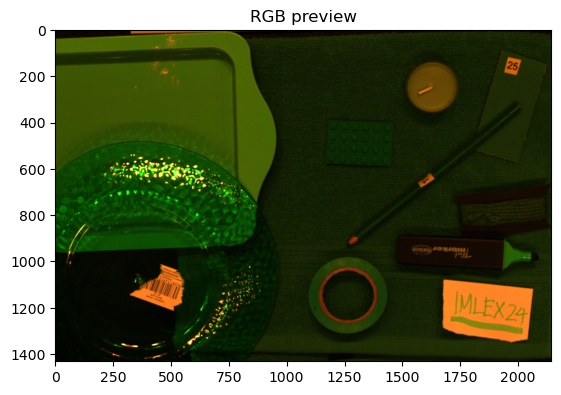

In [9]:
rgb_view = reconstruct_rgb_envi(spectral_image, envi_header)
rgb_view *= 2
rgb_view = rgb_view.clip(0, 1)
plt.imshow(rgb_view)
plt.title("RGB preview")
plt.show()

In [ ]:
def select_area(rgb_view: np.ndarray, select_pos: tuple[slice, slice]) -> np.ndarray:
    _rgb_view = rgb_view.copy()
    _rgb_view[select_pos] = [1, 0, 0]
    return _rgb_view


def get_selected_spectra(spectral_image: np.ndarray, select_pos: tuple[slice, slice]) -> np.ndarray:
    selected_cube = spectral_image[select_pos]
    selected_spectra = selected_cube.mean(axis=(0, 1))
    return selected_spectra


def plot_selected_spectra(
    spectral_image: np.ndarray, select_pos: tuple[slice, slice], wavelengths, ax
) -> None:
    selected_cube = spectral_image[select_pos]

    spectra_per_line = selected_cube.mean(axis=0)
    for i in range(20):
        ax.plot(wavelengths, spectra_per_line[i], alpha=0.2)
    selected_spectra = selected_cube.mean(axis=(0, 1))
    ax.plot(wavelengths, selected_spectra, label="Mean", color="black")
    ax.set_xlabel("Wavelength [nm]")
    ax.set_title("Spectra of selected region")
    ax.legend()


def get_segmented_image(
    spectral_image: np.ndarray, selected_spectra: np.ndarray, threshold: float
) -> np.ndarray:
    diff = np.abs(spectral_image - selected_spectra)
    mask = diff < threshold
    mask = mask.all(axis=2)
    return mask


def get_segmented_rgb_view(rgb_view: np.ndarray, mask: np.ndarray) -> np.ndarray:
    segmented_rgb_view = rgb_view.copy()
    segmented_rgb_view[mask] = [1, 0, 0]
    gray = rgb_view.mean(axis=2)
    segmented_rgb_view[~mask] = gray[~mask][:, None]
    segmented_rgb_view *= 1.5
    segmented_rgb_view = segmented_rgb_view.clip(0, 1)
    return segmented_rgb_view


In [26]:
from asi.utils import get_wavelengths


def plot_segmentation_results(spectral_image, envi_header, select_pos, threshold=0.2):
    rgb_view = reconstruct_rgb_envi(spectral_image, envi_header)
    # calulate all we need
    selected_spectra = get_selected_spectra(spectral_image, select_pos)
    mask = get_segmented_image(spectral_image, selected_spectra, threshold)

    # prepare plot
    fig, axes = plt.subplots(1, 3, tight_layout=True, figsize=(15, 5))
    org_ax = axes[0]
    spectra_ax = axes[1]
    segmented_ax = axes[2]

    # plot selected region
    masked_rgb = select_area(rgb_view, select_pos)
    masked_rgb *= 1.5
    masked_rgb = masked_rgb.clip(0, 1)
    org_ax.imshow(masked_rgb)
    org_ax.set_title("Selected region")

    # plot selected spectra
    wavelengths = get_wavelengths(envi_header)
    plot_selected_spectra(spectral_image, select_pos, wavelengths, spectra_ax)

    # plot segmented
    segmented_rgb_view = get_segmented_rgb_view(rgb_view, mask)
    segmented_ax.imshow(segmented_rgb_view)
    segmented_ax.set_title("Segmented region")
    return fig


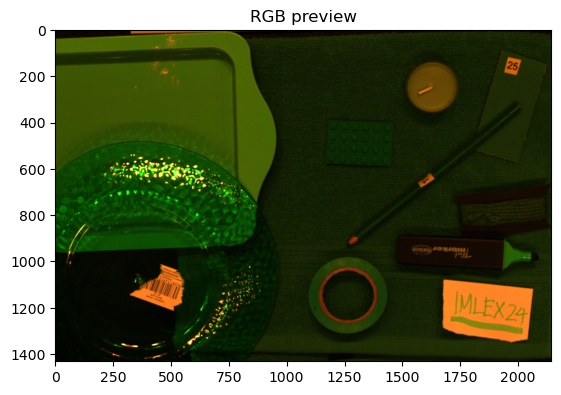

In [12]:
rgb_view = reconstruct_rgb_envi(spectral_image, envi_header)
rgb_view *= 2
rgb_view = rgb_view.clip(0, 1)
plt.imshow(rgb_view)
plt.title("RGB preview")
plt.show()

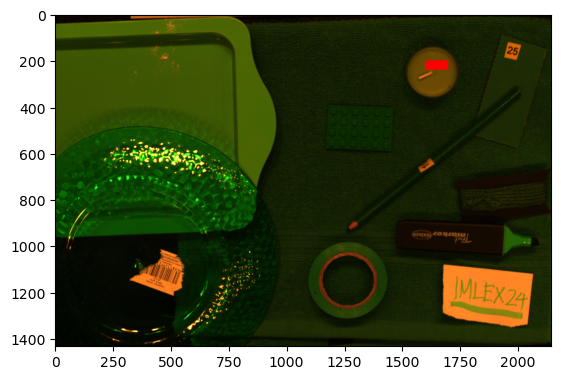

In [ ]:
select_pos = (slice(200, 240), slice(1600, 1700))
r = select_area(rgb_view, select_pos)
plt.imshow(r)

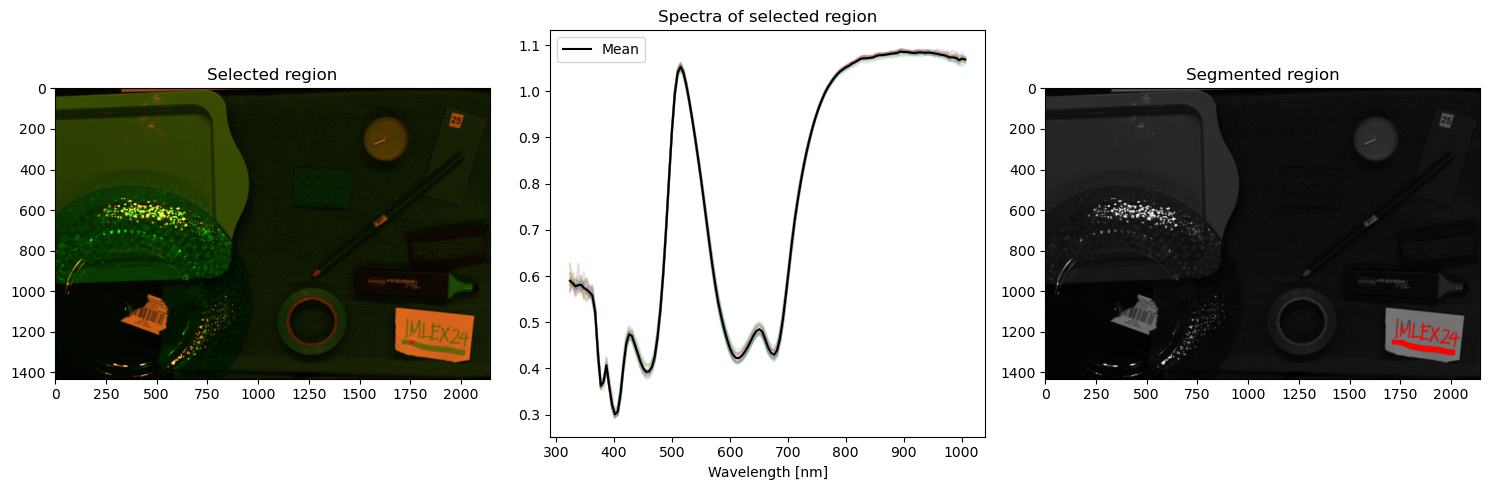

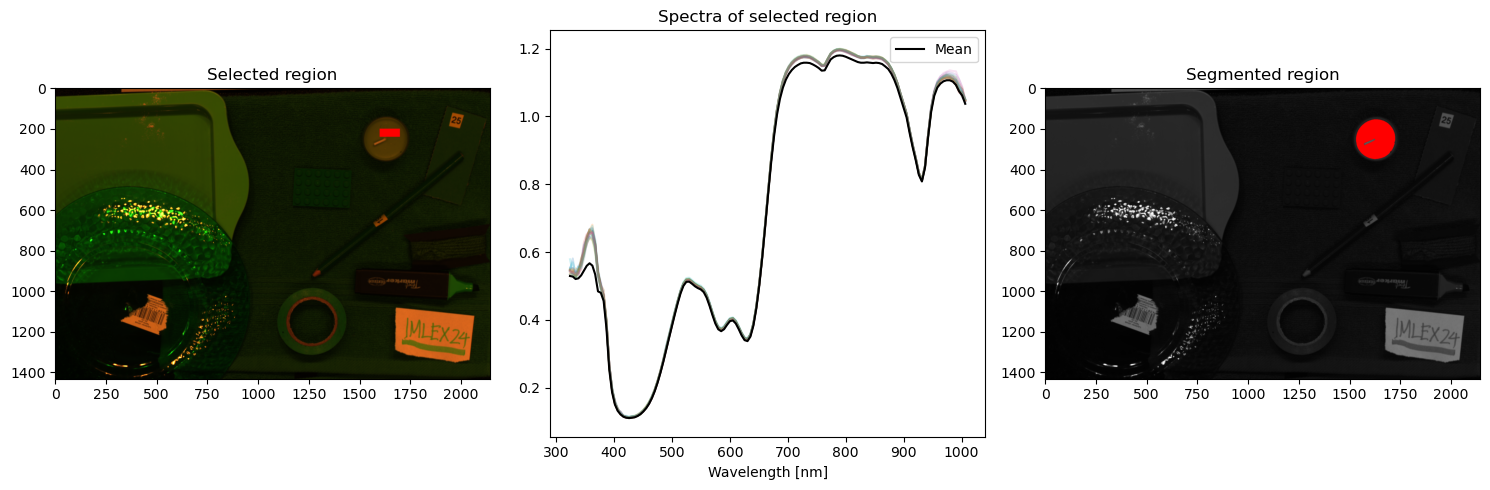

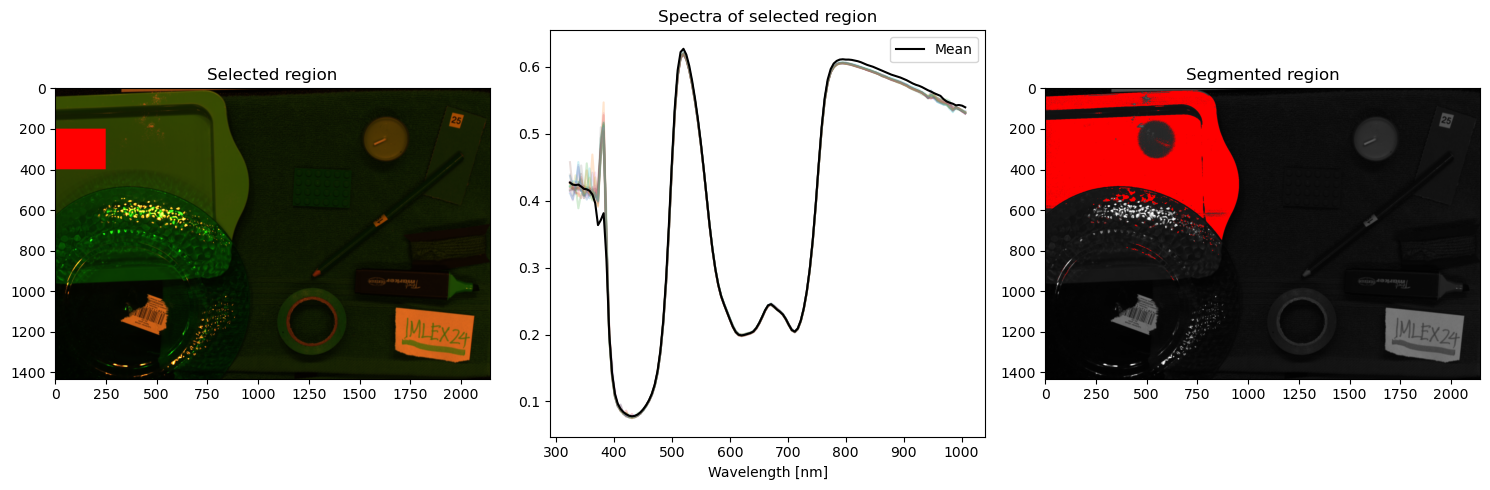

In [35]:
select_pos = (slice(1245, 1260), slice(1750, 1770))
fig = plot_segmentation_results(spectral_image, envi_header, select_pos, threshold=0.3)
plt.show()
select_pos = (slice(200, 240), slice(1600, 1700))
fig = plot_segmentation_results(spectral_image, envi_header, select_pos, threshold=0.3)
plt.show()
select_pos = (slice(200, 400), slice(0, 250))
fig = plot_segmentation_results(spectral_image, envi_header, select_pos)
plt.show()